In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# pepi
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom 


import missingno as msno 
from sklearn.metrics import roc_curve, roc_auc_score, auc

base_dir = '/kaggle/input/siim-isic-melanoma-classification/'
external_base_dir = '/kaggle/input/melanoma-external-malignant-256/'
sns.set(style="darkgrid")

In [ ]:
# Helper functions to be used later
def add_percentage_sns(ax, total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format((height/total)*100),
                ha="center") 
        
        

# 1. Data Analysis
We must first understand what data we have and how it is distributed before actually developing anything, the most important part of Data Science!
To do this we will be using both python frameworks such as pyplot and seaborn, but also Tableau for some more in depth visualisations. 

Let's see what metadata we have about our pacients!



## 1.1 Data exploration and Null values

In [ ]:
train_df = pd.read_csv(base_dir + 'train.csv')
test_df = pd.read_csv(base_dir + '/test.csv')
train_df.head(10)

We have several columns but some of these might not be interesting for now such as the image name, the patient id and the target (since we can use the benign malignant column).
It is also needed to check how much of our information is nulled/outliers.

In [ ]:
train_df.isna().sum().sort_values(ascending=False)

Here are some nice numbers, but it is easier for a human to understand this in the following way:


In [ ]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25, 6))

msno.bar(train_df, ax = ax1)
msno.matrix(train_df, ax = ax2, color=(207/255, 196/255, 171/255), fontsize=10)
msno.matrix(test_df, ax = ax3, color=(218/255, 136/255, 130/255), fontsize=10)

ax1.set_title('Train Missing Values Bar Chart', fontsize = 16)
ax2.set_title('Train Missing Values Map', fontsize = 16)
ax3.set_title('Test Missing Values Map', fontsize = 16);

It is easy to see that we have some null values but nothing out of this world, especially compared to the actual dataset size - 33.126 images of 2.056 different patients! Now we can try to see some interesting information about each of these features We will first analyse the simpler information, age and sex!



## 1.2 Age and Sex


In [ ]:
unique_patients_train = train_df.drop_duplicates('patient_id')
plt.figure(figsize=(6,6))
ax = sns.countplot(x="sex", hue="sex", data=unique_patients_train)
ax.legend(loc='upper center')
add_percentage_sns(ax, unique_patients_train.shape[0])

In [ ]:
plt.xticks(rotation=90)
sns.countplot(train_df['age_approx'], color='blue')

It is easy to retrieve some insights:

* We have more male patients although the difference is not that large
* We have an age distribution that is very normally distributed


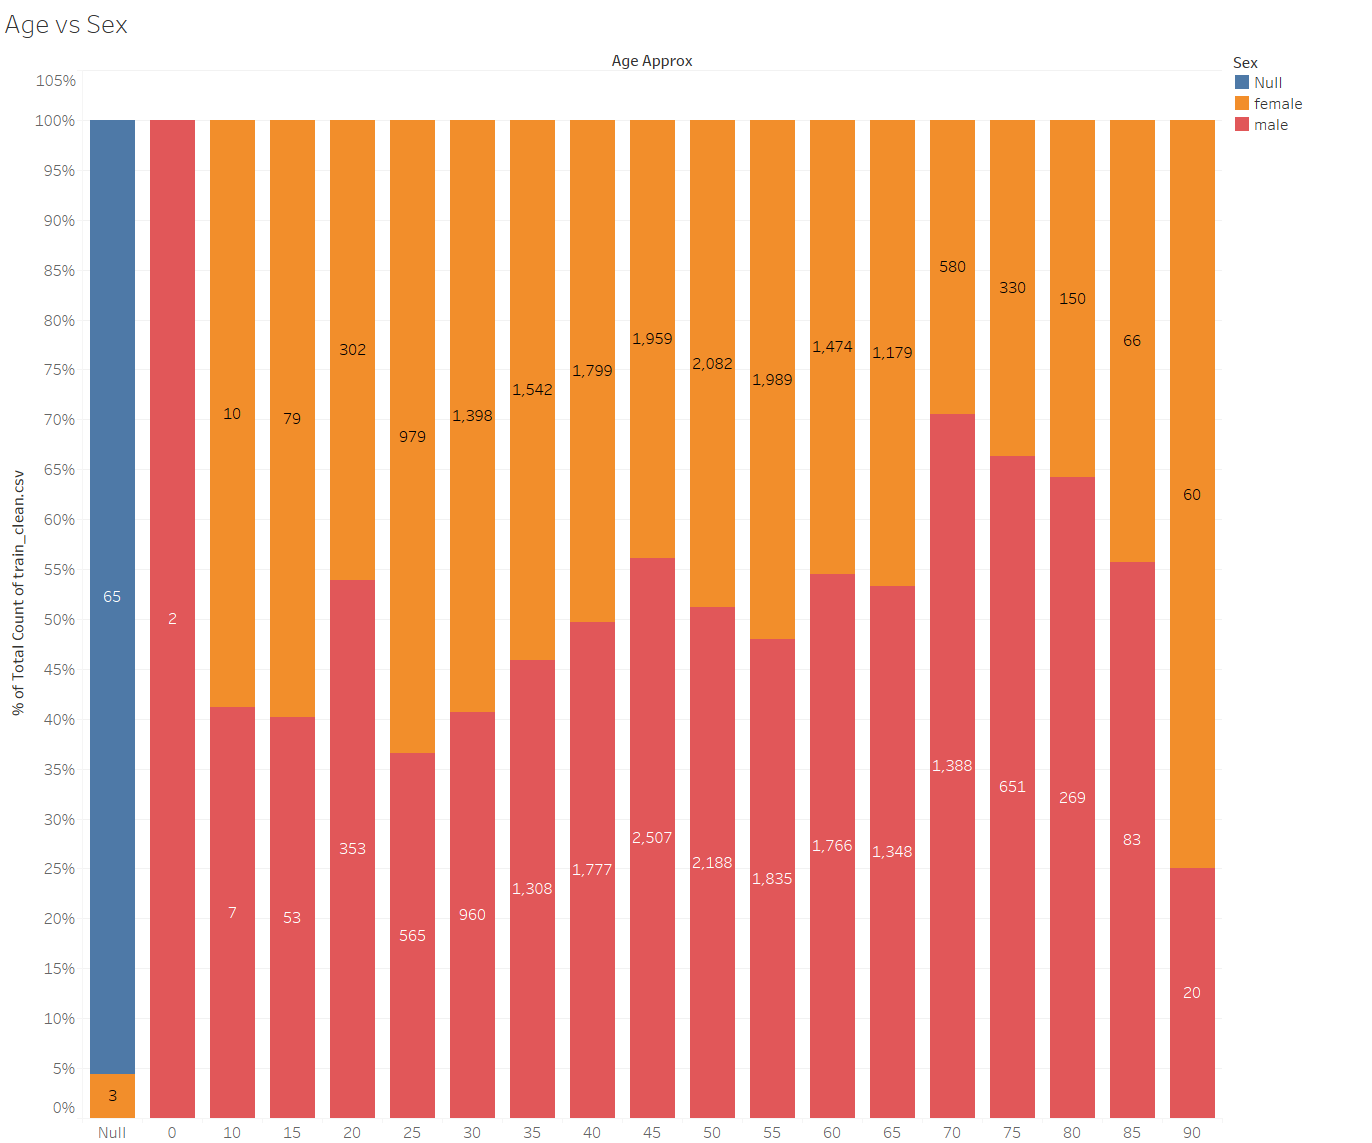
We can already see some outliers, such as only two images that were taken of patients with ages from 0-5, as well as some patients for which we do not have the age nor their sex.
Also we can see that there are some accentuated diferences in the ages compared to the sex of our patients, we have much larger percentage of women over the age of 90. It also seems like for the earlier ages, from 10 to 40, there is a much larger presence of feminine images.






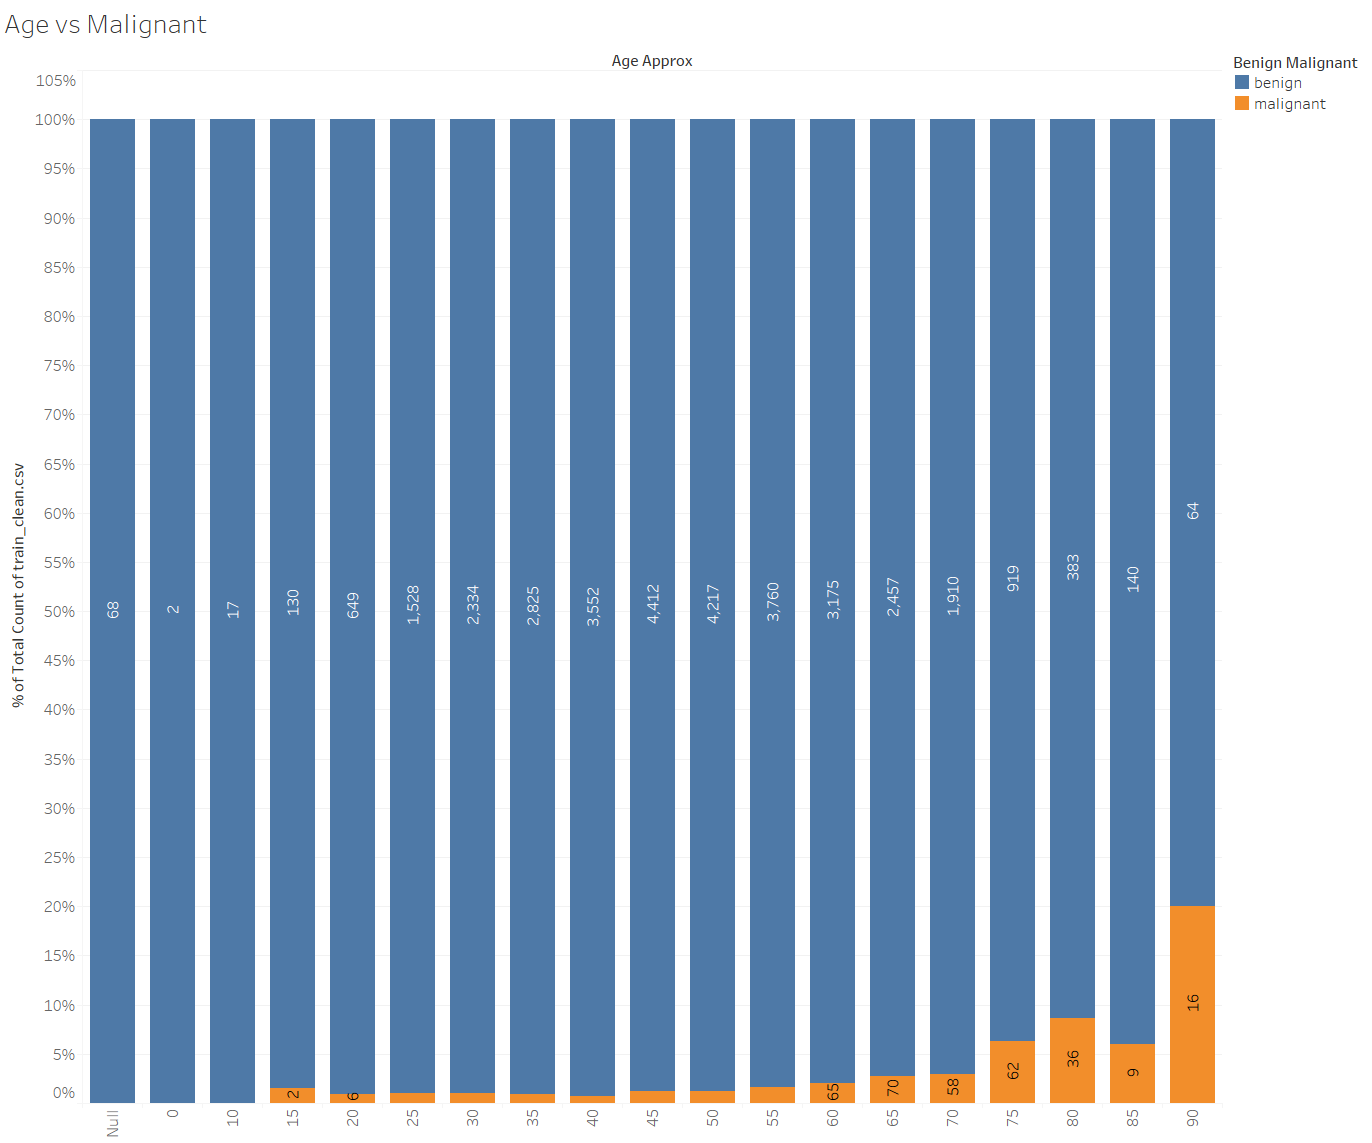
In the image above it is possible to see that there seems to be a very direct correlation between the age of the patients when the image was taken and the possiblity of it being of a malignant lesion, meaning this feature can provide us with some information for the future. Also none of the patients with no data about age ended up testing positive for a malignant melanoma.




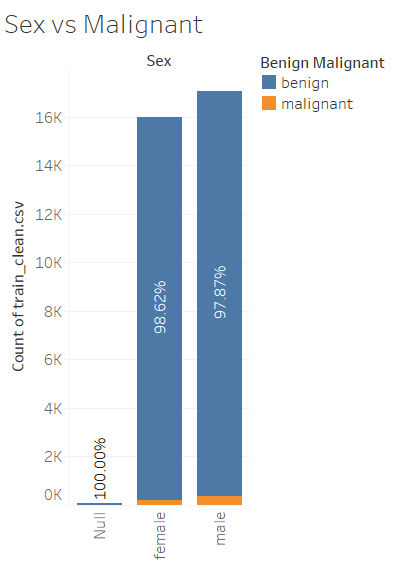
This figure can show that there seems to be a slightly higher percentage of women with positive malignant images than for men. This may, like we saw before, relate to our data having a higher count of older men than women. It is also possible to see that none of our images from patients who did not provide their sex are from cancerigenous lesions.


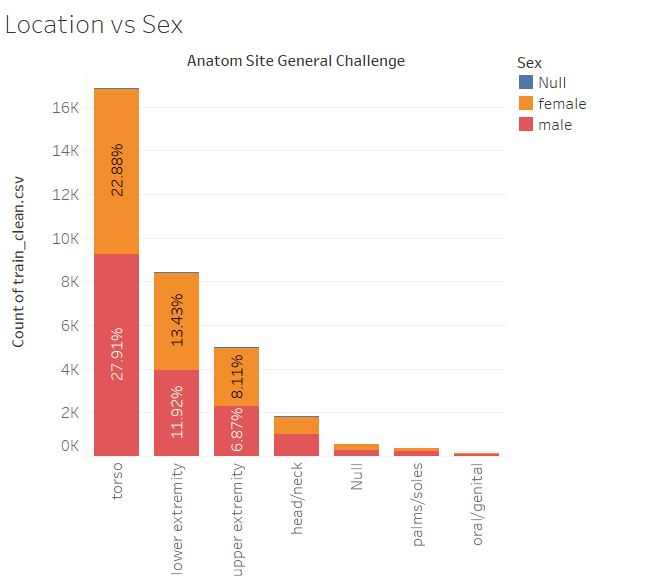
Another interesting thing that we can see in the figure above is that there isn't a distinguishible diference between the location where the images were taken, relative to the sex of our patients!

Let us now look at some other features

In [ ]:
plt.figure(figsize=(10,10))
unique_patients_train = train_df.drop_duplicates('patient_id')
unique_patients_train.shape[0]
sns.distplot(train_df['patient_id'].value_counts(), kde=True, color='blue')

We have only 2056 different patients, where for most of them we have from 1 to 20 images, while for some others we have over 100 images.


In [ ]:
fig, ax = plt.subplots(3,2,figsize=(16,23))

sns.barplot(x=train_df['anatom_site_general_challenge'].value_counts().sort_values(ascending=False).index.values,
            y=train_df['anatom_site_general_challenge'].value_counts().sort_values(ascending=False).values,
            ax=ax[0,0])
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=20, ha='right')
add_percentage_sns(ax[0,0], train_df.shape[0])
ax[0,0].set_title("Distribution of the location")


sns.countplot(train_df['diagnosis'], ax=ax[1,0])
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=20, ha='right')
add_percentage_sns(ax[1,0], train_df.shape[0])
ax[1,0].set_title("Distribution of the diagnosis")


sns.countplot(train_df['benign_malignant'], ax=ax[2,0])
ax[2,0].set_xticklabels(ax[2,0].get_xticklabels(), rotation=20, ha='right')
add_percentage_sns(ax[2,0], train_df.shape[0])
ax[2,0].set_title("Distribution of malignality")

sns.boxplot(train_df['benign_malignant'], train_df['age_approx'], ax=ax[2,1], palette="Greens");
ax[2,1].set_title("Age and cancer");


There is a lot that we can learn from these plots

* We clearly have a lot more data on the torso region, while the oral/genital and palms/soles are very rare on our training data.
* Only 0.02% of our images actually report malignant lesions.
    * This means that we might need to do some data augmentation, worry about metrics such as accuracy.
* Although we have 9 possible classes for the diagnosis of the lesion, we have very little information about most of these classes.


In [ ]:
path_train = base_dir + '/train/' + train_df['image_name'] + '.dcm'
path_test = base_dir + '/test/' + test_df['image_name'] + '.dcm'

train_df['path_dicom'] = path_train
test_df['path_dicom'] = path_test

path_train = base_dir + '/jpeg/train/' + train_df['image_name'] + '.jpg'
path_test = base_dir + '/jpeg/test/' + test_df['image_name'] + '.jpg'

train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test

In [ ]:
def show_images(data, n = 5, rows=1, cols=5, title='Default'):
    plt.figure(figsize=(16,4))

    for k, path in enumerate(data['path_dicom'][:n]):
        image = pydicom.read_file(path)
        image = image.pixel_array
        
        # image = resize(image, (200, 200), anti_aliasing=True)

        plt.suptitle(title, fontsize = 16)
        plt.subplot(rows, cols, k+1)
        plt.imshow(image)
        plt.axis('off')

In [ ]:
show_images(train_df[train_df['target'] == 1], n=10, rows=2, cols=5, title='Malign Sample')

In [ ]:
show_images(train_df[train_df['target'] == 0], n=10, rows=2, cols=5, title='Benign Sample')